# Notebook to generate MEIs for neurons of interest

In [12]:
%matplotlib inline
%load_ext autoreload
%load_ext memory_profiler
import torch
import matplotlib.pyplot as plt
from neuralpredictors.data.datasets import FileTreeDataset
import MEI
import matplotlib as mpl
import os
from os.path import join
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Upload dataset

In [13]:
#Dataset directory
path_dataset = [r'C:\Users\inoca\Desktop\Intership EMBL\Python docs\Inception_loop\Ephy_data_Cortex\static20210629_train']
dataset_name = path_dataset[0].split("\\")[-1].replace('static','')

#Configure dataloader/s 
from lurz2020.datasets.mouse_loaders import static_loaders

dataset_config = {'paths': path_dataset, 
                  'batch_size': 64, 
                  'seed': 1,
                  'cuda': True,
                  'normalize': True, 
                  'include_eye_position': False,
                  'exclude': "images"}

dataloaders = static_loaders(**dataset_config)
dat = FileTreeDataset(path_dataset[0], "images", "responses")

# Upload trained models for MEI generation

In [14]:
#Load best tunned model instances
from lurz2020.models.models import se2d_fullgaussian2d

#Select number of instances to be used
n_seeds = 4

#Models name 
models_name = 'tunned_model_ephy_data_cortex_'

#Directory where the models are saved
path_models = join(path_dataset[0], 'models')

#Build model object to load weights of trained model instances 
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}

models = []
for n in range(n_seeds):
    #Build model object to load weights of trained model instances 
    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders, seed=n)
    #Load weights from saved model state
    model_state = torch.load(join(path_models,models_name+str(n)+'.pth'))
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    #Change model mode to evaluation mode
    model.eval()
    models.append(model)

In [17]:
model.core

SE2dCore(
  (_input_weights_regularizer): LaplaceL2norm(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer1): Sequential(
      (ds_conv): DepthSeparableConv2d(
        (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
        (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer2): Sequential(
      (ds_conv): DepthSeparableConv2d(
        (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=

# MEI generation

In [5]:
#Parameters for MEI generation 
MEIParameter =  {
    #Parameters used for MEI generation for V1 neurons used in paper Walker et al. 2019:
    #1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, True, -1, -1)
    
    'iter_n' : 1000,         # int number of iterations to run
    'start_sigma' : 2.34,   # float starting sigma value
    'end_sigma'   : 0.16,     # float ending sigma value    
    'start_step_size' : 3.0,  # float starting step size  
    'end_step_size' : 0.125,  # float ending step size   
    'precond' : 0.13,          # float strength of gradient preconditioning filter falloff 
    'step_gain' : 0.1,      # float scaling of gradient steps
    'jitter' : 0,             # int size of translational jittering
    'blur' : True,            # bool whether to apply bluring or not 
    'norm' :  -1,             # float norm adjustment after step, negative to turn off
    'train_norm' : -1         # float norm adjustment during step, negative to turn off
}

In [6]:
#Initialize MEI class object by defining model/s, dataset and MEI algorithm parameters to be used 
MEIS = MEI.multi_MEI_class(dataset_name = dataset_name, dat = dat, dataloaders = dataloaders, models = models, n_seeds = n_seeds, MEIParameter = MEIParameter)

In [8]:
#Select target neurons for MEI generation
targets_list = range(3)
for target in targets_list:
    #Generate MEI for one target unit
    mei_target = MEIS.generate(target, track = False) #track=True to plot neuron activation values and corresponding generated images through the gradient ascent algorithm

Working on neuron_id=0
Working with images with mu=127.67724537037037, sigma=55.45213271323961
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.81it/s]


Working on neuron_id=1
Working with images with mu=127.67724537037037, sigma=55.45213271323961
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.11it/s]


Working on neuron_id=2
Working with images with mu=127.67724537037037, sigma=55.45213271323961
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.53it/s]


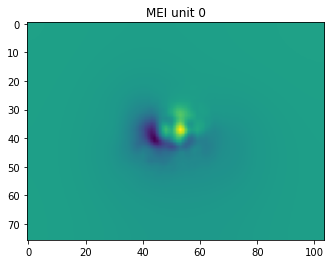

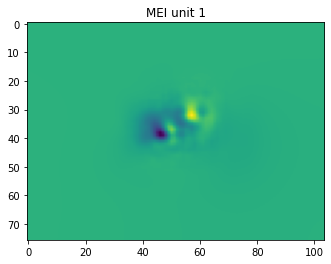

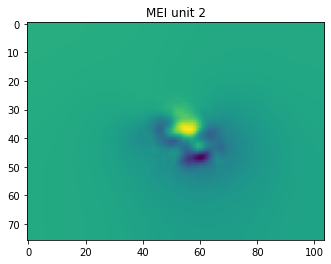

In [9]:
#Directory to save generated MEIs results
path_MEIs = join(path_dataset[0], "results")
os.makedirs(path_MEIs) 

#Plot and save generated MEIs images
for TargetUnit in  targets_list:
    mei_target = MEIS.MEIProperties['neuron_id : '+str(TargetUnit)]['mei']

    fig, axs = plt.subplots(1, figsize=(15,4))
    axs.imshow(mei_target)
    axs.set_title('MEI unit '+str(TargetUnit))
    
    plt.savefig(join(path_MEIs,"MEI_unit_"+str(TargetUnit)+models_name+".png"))

In [10]:
# Save generated MEIS properties from the MEIS object to directory
import pickle 
info_to_save_MEIS = {'dataset_name': MEIS.dataset_name,
                      'models': MEIS.models,
                      'n_seeds': MEIS.n_seeds,
                      'MEIParameter': MEIS.MEIParameter,
                      'MEIProperties': MEIS.MEIProperties}

with open(join(path_MEIs, "MEIS_" + models_name + ".pkl"), 'wb') as file:
    pickle.dump(info_to_save_MEIS, file, pickle.HIGHEST_PROTOCOL)

--------------------------------

In [11]:
torch.cuda.empty_cache()

-----------------------------